## CARA MENJALANKAN
1. Ganti runtime type menjadi GPU pada menu Runtime -> Change runtime type -> pilih GPU -> Save
2. Jalankan semua cell

##Implementasi CUDA dalam Gamma Correction
Gamma dapat digambarkan sebagai hubungan antara input dan output yang dihasilkan. Untuk ruang lingkup percobaan ini inputnya adalah nilai intensitas RGB dari suatu gambar.

Gamma correction juga dikenal sebagai Power Law Transform. Pertama, intensitas piksel gambar kita harus diskalakan dari kisaran [0, 255]. Dari sana, kami mendapatkan gambar output gamma correction dengan menerapkan persamaan berikut:

O = I^(1 / G)

Di mana I adalah gambar input kami dan G adalah nilai gamma kami. Gambar keluaran O kemudian diskalakan kembali ke kisaran [0, 255].

Pada percobaan kali ini kami menggunakan library openCV, numpy, numba, matplotlib, Pillow, dan timeit

##Hardware yang digunakan

In [3]:
!lscpu
!nvidia-smi

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

##Referensi
https://thecryptmag.com/Online/57/imgproc_6.html

Pseudo code yang tersedia pada link referensi

    gammaCorrection = 1 / gamma
    colour = GetPixelColour(x, y)
    newRed = 255 * (Red(colour) / 255) ^ gammaCorrection
    newGreen = 255 * (Green(colour) / 255) ^ gammaCorrection
    newBlue = 255 * (Blue(colour) / 255) ^ gammaCorrection
    PutPixelColour(x, y) = RGB(newRed, newGreen, newBlue)

##Import library yang dibutuhkan

In [4]:

import cv2
import numpy as np
import numba
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer  
     

##Import Gambar Bahan Uji

In [3]:
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_256.jpg
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_512.jpg
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_1024.jpg
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_2048.jpg
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_4096.jpg
!wget https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_8192.jpg

--2022-12-20 18:01:07--  https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_256.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91903 (90K) [image/jpeg]
Saving to: ‘thispersondoesntexist_256.jpg’

thispersondoesntexi 100%[===================>]  89.75K  --.-KB/s    in 0.01s   

2022-12-20 18:01:07 (6.34 MB/s) - ‘thispersondoesntexist_256.jpg’ saved [91903/91903]

--2022-12-20 18:01:07--  https://raw.githubusercontent.com/fikriidk/Numba-Gamma/main/images/thispersondoesntexist_512.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

##Load Gambar

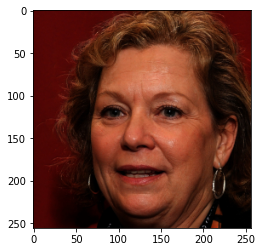

In [5]:
img_256 = cv2.imread('thispersondoesntexist_256.jpg')
img_256 = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
plt.imshow(img_256)

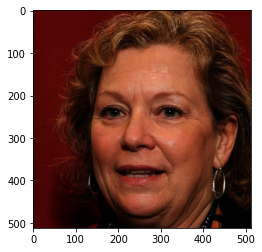

In [12]:
img_512 = cv2.imread('thispersondoesntexist_512.jpg')
img_512 = cv2.cvtColor(img_512, cv2.COLOR_BGR2RGB)
plt.imshow(img_512)

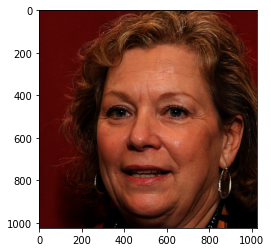

In [13]:
img_1024 = cv2.imread('thispersondoesntexist_1024.jpg')
img_1024 = cv2.cvtColor(img_1024, cv2.COLOR_BGR2RGB)
plt.imshow(img_1024)

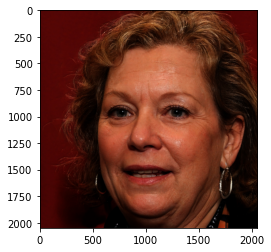

In [14]:
img_2048 = cv2.imread('thispersondoesntexist_2048.jpg')
img_2048 = cv2.cvtColor(img_2048, cv2.COLOR_BGR2RGB)
plt.imshow(img_2048)

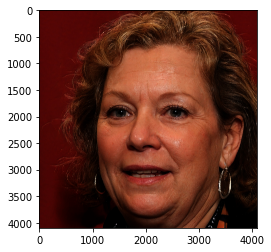

In [15]:
img_4096 = cv2.imread('thispersondoesntexist_4096.jpg')
img_4096 = cv2.cvtColor(img_4096, cv2.COLOR_BGR2RGB)
plt.imshow(img_4096)

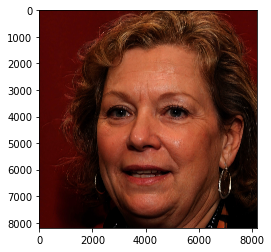

In [16]:
img_8192 = cv2.imread('thispersondoesntexist_8192.jpg')
img_8192  = cv2.cvtColor(img_8192 , cv2.COLOR_BGR2RGB)
plt.imshow(img_8192 )

In [6]:
# Melihat 2 baris awal matriks untuk gambar beresolusi 256

# 2 baris awal matriks
img_256[:2,:]

array([[[69,  9,  9],
        [78,  7,  5],
        [82,  6,  8],
        ...,
        [79,  5,  6],
        [76,  6,  4],
        [68,  8,  7]],

       [[78,  6,  7],
        [81,  5,  7],
        [78,  7,  5],
        ...,
        [79,  5,  6],
        [75,  7,  6],
        [75,  7,  8]]], dtype=uint8)

In [7]:
#Penjelasan Dimensi sample gambar 256x256 pixel

dimensi = img_256.shape
tinggi = img_256.shape[0]
lebar = img_256.shape[1]
channel = img_256.shape[2]

print('====== Gambar 256x256 pixel ====== \n')
print('Dimensi Gambar      : ',dimensi)
print('Tinggi Gambar       : ',tinggi) #kolom
print('Lebar Gambar        : ',lebar) #baris
print('Banyaknya Channel   : ',channel) #3 channel berarti RGB

====== Gambar 256x256 pixel ====== 

Dimensi Gambar      :  (256, 256, 3)
Tinggi Gambar       :  256
Lebar Gambar        :  256
Banyaknya Channel   :  3


In [17]:
#Penjelasan Dimensi sample gambar 8192x8192 pixel

dimensi = img_8192.shape
tinggi = img_8192.shape[0]
lebar = img_8192.shape[1]
channel = img_8192.shape[2]

print('====== Gambar 256x256 pixel ====== \n')
print('Dimensi Gambar      : ',dimensi)
print('Tinggi Gambar       : ',tinggi) #kolom
print('Lebar Gambar        : ',lebar) #baris
print('Banyaknya Channel   : ',channel) #3 channel berarti RGB


====== Gambar 256x256 pixel ====== 

Dimensi Gambar      :  (8192, 8192, 3)
Tinggi Gambar       :  8192
Lebar Gambar        :  8192
Banyaknya Channel   :  3


In [18]:
maxValue = np.amax(img_8192)

##Pembuatan Dictionary Image
Dictionary digunakan untuk menyimpan nilai data dalam pasangan key:value. Dictionary adalah kumpulan yang "dipesan", dapat diubah dan tidak memungkinkan duplikat.

Penggunaan dictionary ini bertujuan untuk mempermudah dalam mengeksekusi

In [19]:
#Pembuatan dictionary supaya mudah dalam melakukan eksekusi secara langsung dengan looping

dictsImages = {} #dictionary kosong yang akan diisi dengan key (angka 0 - 3) dan values (gambar 256 hingga 8192)
keys = range(6)
values = [img_256, img_512, img_1024, img_2048, img_4096, img_8192]
for i in keys:
        dictsImages[i] = values[i]
print(dictsImages)

{0: array([[[69,  9,  9],
        [78,  7,  5],
        [82,  6,  8],
        ...,
        [79,  5,  6],
        [76,  6,  4],
        [68,  8,  7]],

       [[78,  6,  7],
        [81,  5,  7],
        [78,  7,  5],
        ...,
        [79,  5,  6],
        [75,  7,  6],
        [75,  7,  8]],

       [[81,  5,  5],
        [80,  4,  4],
        [82,  6,  6],
        ...,
        [79,  5,  4],
        [78,  7,  5],
        [77,  7,  7]],

       ...,

       [[65,  4,  3],
        [72,  7,  5],
        [73,  7,  8],
        ...,
        [ 1,  1,  1],
        [ 2,  2,  2],
        [ 1,  1,  1]],

       [[67,  7,  7],
        [67,  6,  5],
        [71,  5,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[56,  6,  9],
        [68,  7,  6],
        [69,  5,  5],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 0,  0,  0]]], dtype=uint8), 1: array([[[71, 15, 16],
        [68,  6,  7],
        [76,  8,  9],
        ...,
     

without GPU: 236.500045108
25 ns ± 0.755 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


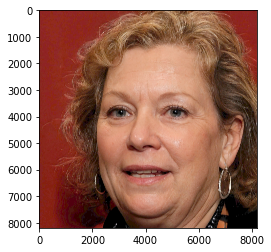

In [20]:
def gamma_correction_seq (image, gamma):
  init_image = np.zeros(image.shape, np.uint8) #inisialisasi variabel init_image dengan value setiap index pada matrix = 0 menggunakan numpy.zeros
  for i in range(image.shape[0]):  # baris
    for j in range(image.shape[1]):  # kolom
      init_image[i][j] = 255.0 * (image[i][j] / 255.0)**(1 / gamma) #mengisi setiap index matrix dengan formula gamma correction yang didapat dari https://thecryptmag.com/Online/57/imgproc_6.html
  return init_image # mengembalikan matrix init_image

########
# Waktu start menggunakan default timer https://docs.python.org/3/library/time.html#time.perf_counter 
# Mengembalikan nilai (dalam pecahan detik), tidak termasuk waktu yang berlalu selama sleep.
########
start = timer() 
gm_seq = gamma_correction_seq(img_8192,2) #menjalankan fungsi gamma_correction_seq
end = timer() - start
print("without GPU:", end) #print waktu runtime (waktu sekarang - waktu start)
%timeit gm_seq # melihat berapa waktu terbaik yang dibutuhkan per looping https://docs.python.org/3/library/timeit.html
plt.imshow(gm_seq) # plot gambar hasil

##Menghitung waktu runtime secara sequensial untuk setiap key dan value pada dictionary gambar yang telah dibuat di atas


In [21]:
time_seq = {} #dictionary untuk waktu runtime
output_seq = {} #dictionary untuk output matrix
for keys,values in dictsImages.items():
  start = timer()
  output_seq[keys]=gamma_correction_seq(values, 2)
  time_seq[keys] =  timer() - start
time_seq #waktu runtime untuk setiap key dan value

{0: 0.24745985000004111,
 1: 0.9124843029999283,
 2: 4.379054180000139,
 3: 14.815080413000032,
 4: 64.85118028199986,
 5: 256.2207778860002}

##Gamma Correction secara parallel dengan numba vectorize decorator
Numba’s vectorize allows Python functions taking scalar input arguments to be used as NumPy ufuncs. Creating a traditional NumPy ufunc is not the most straightforward process and involves writing some C code. Numba makes this easy. Using the vectorize() decorator, Numba can compile a pure Python function into a ufunc that operates over NumPy arrays as fast as traditional ufuncs written in C.

Using vectorize(), you write your function as operating over input scalars, rather than arrays. Numba will generate the surrounding loop (or kernel) allowing efficient iteration over the actual inputs.

[Dokumentasi Numba](https://numba.readthedocs.io/en/stable/user/vectorize.html#the-vectorize-decorator)

with GPU: 2.7282513919999474
22.9 ns ± 0.9 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


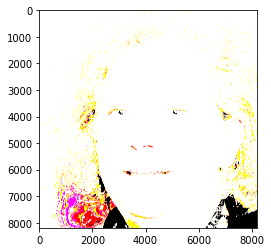

In [22]:
@numba.vectorize('uint8(uint8,float64)',target='cuda')     #menggunakan numba vectorize decorator dengan target cuda (GPU)    

####### 
#Arti dari fungsi ini adalah gamma_correction_par yang menggunakan numba vectorize(numba telah membuatkan loop(atau kernel) yang  memungkonkan iterasi atas inputan kita)
#kemudian fungsi gamma_correction_par akan mengembalikan nilai setiap index matrix yang valuenya adalah hasil dari formula gamma correction 
#######
def gamma_correction_par(image,gamma):
  return 255.0 * (image / 255.0)**(1 / gamma) 

########
# Waktu start menggunakan default timer https://docs.python.org/3/library/time.html#time.perf_counter 
# Mengembalikan nilai (dalam pecahan detik), tidak termasuk waktu yang berlalu selama sleep.
########
start = timer() 
gm_par = gamma_correction_par(img_8192,2) #menjalankan fungsi gamma_correction_par
end = timer() - start
print("with GPU:", end) #print waktu runtime (waktu sekarang - waktu start)
%timeit gm_par # melihat berapa waktu terbaik yang dibutuhkan per looping https://docs.python.org/3/library/timeit.html
plt.imshow(gm_par) # plot gambar hasil
     

##Menghitung waktu runtime secara sequensial untuk setiap key dan value pada dictionary gambar yang telah dibuat di atas


In [23]:
time_par = {} # dictionary untuk waktu runtime
output_par = {} # dictionary untuk output matrix
for keys,values in dictsImages.items():
  start = timer()
  output_par[keys]=gamma_correction_par(values, 2)
  time_par[keys] =  timer() - start
time_par # waktu runtime untuk setiap key dan value

{0: 0.010891368999637052,
 1: 0.009091381999951409,
 2: 0.028181783000036376,
 3: 0.10524037499999395,
 4: 0.348395384000014,
 5: 1.4352761189998091}

##Visualisasi Data Runtime Dengan Grafik
Grafik ini digunakan untuk visualisasi perbandingan waktu eksekusi antara sequential dengan parallel

In [24]:
x = sorted(list(map(int,time_seq.keys())))
x

[0, 1, 2, 3, 4, 5]

##Grafik Runtime secara seri/sequential menggunakan CPU

In [25]:
print('==== Runtime CPU ====')
print(time_seq)
print('\n\n==== Runtime GPU ====')
print(time_par)

==== Runtime CPU ====
{0: 0.24745985000004111, 1: 0.9124843029999283, 2: 4.379054180000139, 3: 14.815080413000032, 4: 64.85118028199986, 5: 256.2207778860002}


==== Runtime GPU ====
{0: 0.010891368999637052, 1: 0.009091381999951409, 2: 0.028181783000036376, 3: 0.10524037499999395, 4: 0.348395384000014, 5: 1.4352761189998091}


In [26]:
#Grafik Runtime Menggunakan CPU

def graph_seq(dictionary_sequential,title):
  plt.figure(figsize=(20,12))
  x = sorted(list(map(int,dictionary_sequential.keys()))) #Mengambil dan mengurutkan Key yang diambil dari dictionary time_seq 
  y_seq= [dictionary_sequential[i] for i in x] # mengambil waktu eksekusi parallel
  labels = ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"] # Label untuk sumbu X
  plt.plot(x,y_seq,marker='o', c="g") # plot grafik parallel dengan warna hijau
  plt.xticks(x,labels) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html?highlight=xtick Mengubah untuk setiap koordinat yang semulanya berisi key dari dictionary [0, 1, 2, 3, 4, 5] menjadi label ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"]
  plt.xlabel('Resolusi gambar (px)')
  plt.ylabel('Waktu dalam satuan detik (s)')
  plt.title(title)
  plt.show
     

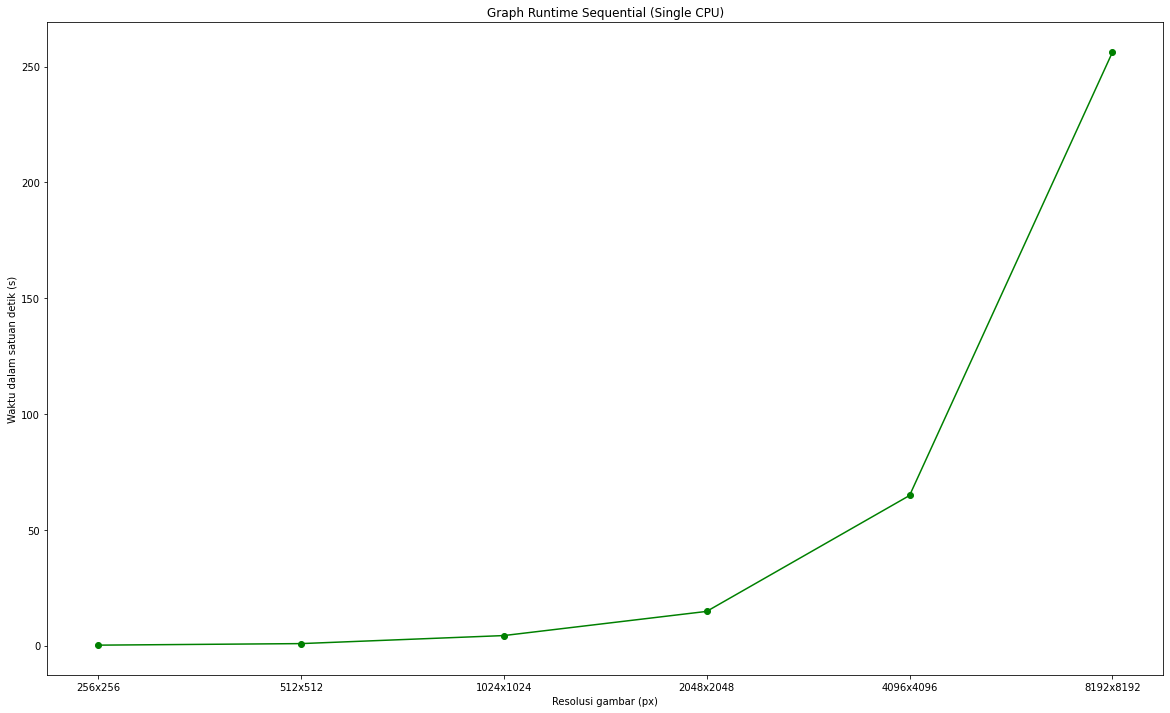

In [27]:
graph_seq(time_seq,"Graph Runtime Sequential (Single CPU)")

##Grafik Runtime secara paralel menggunakan CUDA

In [28]:
#Grafik Runtime Menggunakan CUDA

def graph_par(dictionary_parallel,title):
  plt.figure(figsize=(20,12))
  x = sorted(list(map(int,dictionary_parallel.keys()))) #Mengambil dan mengurutkan Key yang diambil dari dictionary time_seq 
  y_par= [dictionary_parallel[i] for i in x] # mengambil waktu eksekusi parallel
  labels = ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"] # Label untuk sumbu X
  plt.plot(x,y_par,marker='o', c="g") # plot grafik parallel dengan warna hijau
  plt.xticks(x,labels) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html?highlight=xtick Mengubah untuk setiap koordinat yang semulanya berisi key dari dictionary [0, 1, 2, 3, 4, 5] menjadi label ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"]
  plt.xlabel('Resolusi gambar (px)')
  plt.ylabel('Waktu dalam satuan detik (s)')
  plt.title(title)
  plt.show


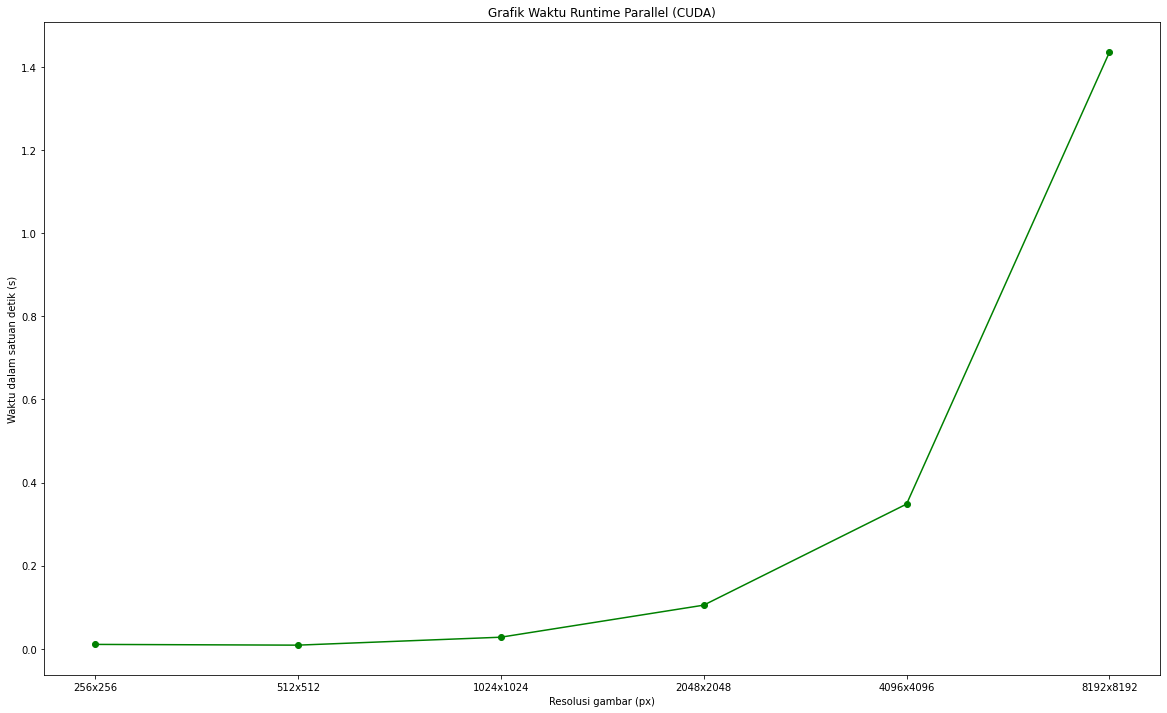

In [29]:
graph_par(time_par,"Grafik Waktu Runtime Parallel (CUDA)")

##Grafik Perbandingan Waktu Runtime CPU vs CUDA

In [30]:

#Grafik Perbandingan Waktu Runtime CPU vs CUDA

def graph(dictionary_sequential,dictionary_parallel,title):
  plt.figure(figsize=(20,12))
  x = sorted(list(map(int,dictionary_sequential.keys()))) #Mengambil dan mengurutkan Key yang diambil dari dictionary time_seq 
  y_seq= [dictionary_sequential[i] for i in x] # mengambil waktu eksekusi sequential
  y_par= [dictionary_parallel[i] for i in x] # mengambil waktu eksekusi parallel
  labels = ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"] # Label untuk sumbu X
  plt.plot(x,y_seq,marker='o', c="r") # plot grafix sequential dengan warna merah
  plt.plot(x,y_par,marker='o', c="g") # plot grafik parallel dengan warna hijau
  plt.ylim(ymin=-1)
  plt.xticks(x,labels) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html?highlight=xtick Mengubah untuk setiap koordinat yang semulanya berisi key dari dictionary [0, 1, 2, 3, 4, 5] menjadi label ["256x256", "512x512", "1024x1024", "2048x2048", "4096x4096", "8192x8192"]
  plt.xlabel('Resolusi gambar (px)')
  plt.ylabel('Waktu dalam satuan detik (s)')
  plt.legend(['Single CPU','CUDA'])
  plt.title(title)
  plt.show



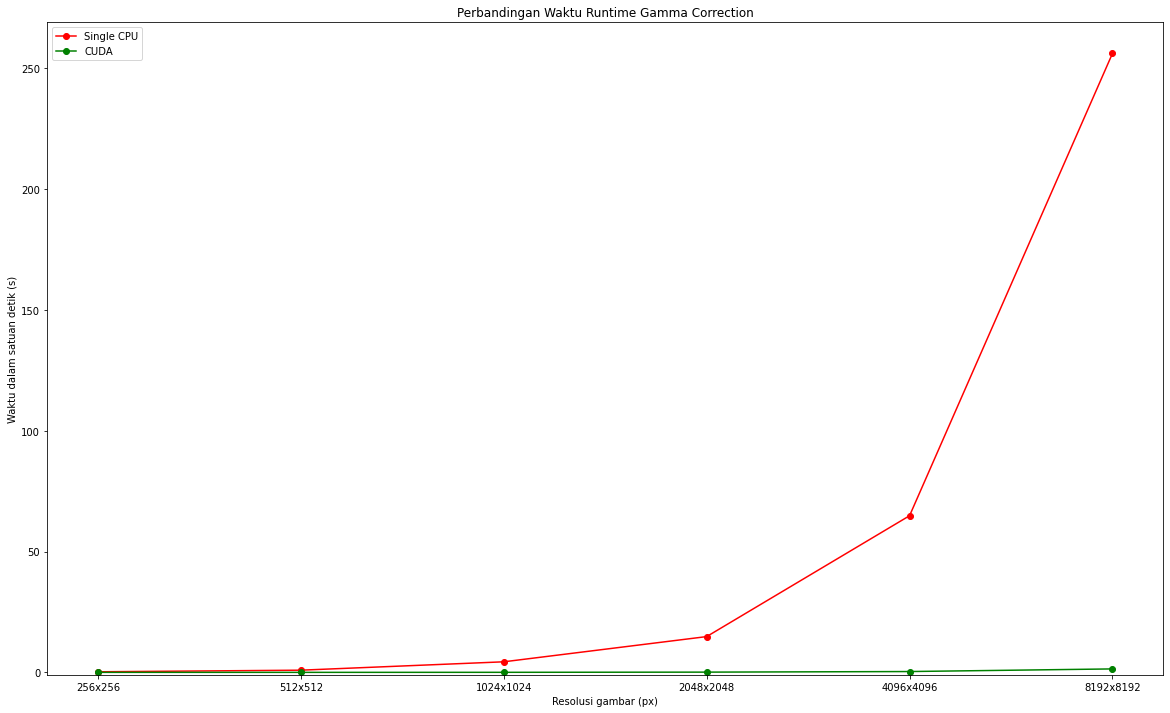

In [31]:
graph(time_seq,time_par,"Perbandingan Waktu Runtime Gamma Correction")